In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

import torch.nn as nn

In [2]:
n_train = 600
n_test  = 100
num_qubits = 4
n_weights = 12

batch_size = 64
n_epochs = 20

In [3]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev,interface="torch", diff_method="adjoint")
def circuit(inputs, weights):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
        qml.Hadamard(wires=j)
        
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,3])
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    qml.Rot(weights[6], weights[7], weights[8], wires=2)
    qml.Rot(weights[9], weights[10], weights[11], wires=3)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [4]:
def load_dataset(n_train, n_test, batch_size):
    """
    Loads train & test sets from MNIST with user-specified sizes.

    Args:
        n_train (int): Desired number of samples in the training set.
        n_test (int): Desired number of samples in the testing set.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: (train_loader, test_loader) where each loader is a
               torch.utils.data.DataLoader.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (0.5,)),
                                    transforms.Lambda(lambda img: F.interpolate(img.unsqueeze(0), size=(16, 16), 
                                        mode='bilinear', align_corners=False).squeeze(0))])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Subset the datasets to the desired number of samples
    train_subset = torch.utils.data.Subset(train_dataset, range(n_train))
    test_subset = torch.utils.data.Subset(test_dataset, range(n_test))

    # Create DataLoaders for training and testing sets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    print("Number of training samples:", len(train_subset))
    print("Number of test samples:", len(test_subset))

    return train_loader, test_loader

/var/folders/pc/01wnjzvx01n_gqvkhmw2_9nr0000gn/T/ipykernel_22098/3575164432.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


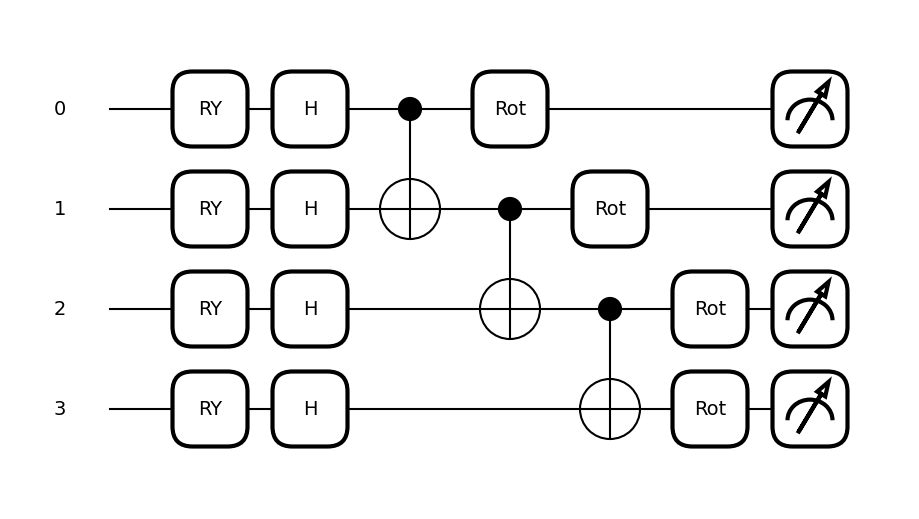

In [5]:
qlayer = qml.qnn.TorchLayer(circuit, {"weights": (n_weights,)})
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], [1,2,3,4,5,123,2,23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
fig.show()

In [6]:
def extract_image_patches(x):
    # Do TF 'SAME' Padding
    B, C, H, W = x.shape  
    #x = torch.arange(B*C*H*W).view(B, C, H, W)
    kernel_h, kernel_w = 2, 2
    stride = 4

    patches = x.unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
      
    patches = patches.contiguous().view(B, H // stride, W // stride, -1)

    return patches.reshape(-1, 4)

In [7]:
def swish(x):
    return x * torch.sigmoid(x)

In [8]:
class HQNN(nn.Module):
    def __init__(self):
        super(HQNN, self).__init__()

        # Quanvolutional layer (Maps 1 input channel to 4 output channels)
        self.quanv = qlayer

        # Fully connected layer to perform the final classification
        self.fc1 = nn.Linear(4 * 4 * 4, 10)  # Assuming 10 output classes

    def forward(self, input):
        patches = extract_image_patches(input)  

        quanvoluted_patches = torch.stack([self.quanv(patch) for patch in patches])
        x = quanvoluted_patches.reshape(input.shape[0], 4, 4, 4)

        #x = swish(x)
        x = x.view(-1, 4 * 4 * 4)  # Flatten for the fully connected layer
        x = self.fc1(x)
        x = F.softmax(x, dim=1)  # Apply softmax
        return x

In [9]:
model = HQNN() 

optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97) 

loss_fn = F.cross_entropy

train_loader, test_loader = load_dataset(n_train, n_test, batch_size)

Number of training samples: 600
Number of test samples: 100


In [10]:
"""test_model = HQNN()
optimizer_test = torch.optim.SGD(model.parameters(), momentum=0.9, nesterov=True)

base_test = 3e-4
max_test = 0.1

stepsize_test = 40  # Adjust as needed
max_iter = stepsize_test   # One cycle

test_scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer_test,
    base_lr=base_test,
    max_lr=max_test,
    step_size_up=stepsize_test,
    mode='triangular',
)

accuracies = []  
learning_rates = [] 

train_tester, _ = load_dataset(50, 1, 50)

for epoch in range(max_iter):
    for i, (images, labels) in enumerate(train_tester):
        output = test_model(images)
        
        loss = loss_fn(output, labels)  
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()
        test_scheduler.step()  # Update learning rate

        # Record accuracy and learning rate
        _, predicted = torch.max(output.data, 1)
        accuracy = (predicted == labels).sum().item() / 50
        accuracies.append(accuracy)
        learning_rates.append(test_scheduler.get_last_lr()[0])

plt.plot(learning_rates, accuracies)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning Rate (Triangular Policy)")
plt.show()

# This tests optimal LR max and min"""

'test_model = HQNN()\noptimizer_test = torch.optim.SGD(model.parameters(), momentum=0.9, nesterov=True)\n\nbase_test = 3e-4\nmax_test = 0.1\n\nstepsize_test = 40  # Adjust as needed\nmax_iter = stepsize_test   # One cycle\n\ntest_scheduler = torch.optim.lr_scheduler.CyclicLR(\n    optimizer_test,\n    base_lr=base_test,\n    max_lr=max_test,\n    step_size_up=stepsize_test,\n    mode=\'triangular\',\n)\n\naccuracies = []  \nlearning_rates = [] \n\ntrain_tester, _ = load_dataset(50, 1, 50)\n\nfor epoch in range(max_iter):\n    for i, (images, labels) in enumerate(train_tester):\n        output = test_model(images)\n        \n        loss = loss_fn(output, labels)  \n        optimizer_test.zero_grad()\n        loss.backward()\n        optimizer_test.step()\n        test_scheduler.step()  # Update learning rate\n\n        # Record accuracy and learning rate\n        _, predicted = torch.max(output.data, 1)\n        accuracy = (predicted == labels).sum().item() / 50\n        accuracies.app

In [11]:
for epoch in range(n_epochs):

    # ---- Training Phase ----
    running_loss = 0.0 
    correct = 0  
    total = 0
    train_losses = []
    test_losses = []
    start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # --- 2. Forward Pass ---
        outputs = model(images)

        # --- 3. Loss Calculation ---
        loss = loss_fn(outputs, labels)
        train_losses.append(loss.item())
        # --- 4. Backpropagation and Optimization ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  
        train_losses.append(loss.item())  # Store loss for each batch

        # Accuracy calculation for the epoch
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()

    # Print statistics for the epoch
    epoch_loss = sum(train_losses) / len(train_losses)  
    epoch_acc = 100 * correct / total 

    #current_lr = scheduler.get_last_lr()[0]  

    # Periodic Evaluation and Logging
    print(f'[i] Epoch {epoch + 1}\n\tLoss: {epoch_loss:.4f}\tAccuracy: {epoch_acc :.2f}%\n\tElapsed Time: {time.time() - start_time:.2f}s')
    #print(f'\tLearning Rate: {current_lr}\n')

[i] Epoch 1
	Loss: 2.2956	Accuracy: 14.00%
	Elapsed Time: 10.09s
[i] Epoch 2
	Loss: 2.2536	Accuracy: 19.50%
	Elapsed Time: 10.39s
[i] Epoch 3
	Loss: 2.2035	Accuracy: 31.00%
	Elapsed Time: 10.37s
[i] Epoch 4
	Loss: 2.1420	Accuracy: 35.50%
	Elapsed Time: 10.16s
[i] Epoch 5
	Loss: 2.0967	Accuracy: 41.17%
	Elapsed Time: 10.36s
[i] Epoch 6
	Loss: 2.0553	Accuracy: 41.50%
	Elapsed Time: 10.38s
[i] Epoch 7
	Loss: 2.0333	Accuracy: 46.67%
	Elapsed Time: 10.52s
[i] Epoch 8
	Loss: 2.0276	Accuracy: 45.33%
	Elapsed Time: 10.24s
[i] Epoch 9
	Loss: 2.0034	Accuracy: 48.33%
	Elapsed Time: 10.43s
[i] Epoch 10
	Loss: 1.9753	Accuracy: 51.83%
	Elapsed Time: 10.51s
[i] Epoch 11
	Loss: 1.9590	Accuracy: 52.67%
	Elapsed Time: 10.39s
[i] Epoch 12
	Loss: 1.9332	Accuracy: 54.83%
	Elapsed Time: 10.39s
[i] Epoch 13
	Loss: 1.9229	Accuracy: 56.17%
	Elapsed Time: 10.35s
[i] Epoch 14
	Loss: 1.9178	Accuracy: 57.83%
	Elapsed Time: 10.44s
[i] Epoch 15
	Loss: 1.9019	Accuracy: 57.50%
	Elapsed Time: 10.27s
[i] Epoch 16
	Loss:

In [12]:
model.eval()  # Set model to evaluation mode
val_loss = 0.0
val_corrects = 0

with torch.no_grad():  # Disable gradients for evaluation
    val_correct = 0
    val_total = 0

    for images, labels in test_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss = sum(test_losses) / len(test_losses)
val_acc = 100 * val_correct / val_total 

print(f'[i] Val Loss: {val_loss:.4f}\t Val Accuracy: {val_acc :.2f}%')
print("[p] Val Loss: 1.90	 Val Accuracy: 58.00%")

[i] Val Loss: 1.9217	 Val Accuracy: 56.00%
[p] Val Loss: 1.90	 Val Accuracy: 58.00%
